# Title : News Headlines Dataset For Sarcasm Detection

**It is a classification problem that determines whether or not it is a sarcasm through the headline of a news article.**

**Context**

Past studies in Sarcasm Detection mostly make use of Twitter datasets collected using hashtag based supervision but such datasets are noisy in terms of labels and language. Furthermore, many tweets are replies to other tweets and detecting sarcasm in these requires the availability of contextual tweets.

To overcome the limitations related to noise in Twitter datasets, this News Headlines dataset for Sarcasm Detection is collected from two news website. TheOnion aims at producing sarcastic versions of current events and we collected all the headlines from News in Brief and News in Photos categories (which are sarcastic). We collect real (and non-sarcastic) news headlines from HuffPost.

This new dataset has following advantages over the existing Twitter datasets:

Since news headlines are written by professionals in a formal manner, there are no spelling mistakes and informal usage. This reduces the sparsity and also increases the chance of finding pre-trained embeddings.

Furthermore, since the sole purpose of TheOnion is to publish sarcastic news, we get high-quality labels with much less noise as compared to Twitter datasets.

Unlike tweets which are replies to other tweets, the news headlines we obtained are self-contained. This would help us in teasing apart the real sarcastic elements.

**Content**

Each record consists of three attributes:

is_sarcastic: 1 if the record is sarcastic otherwise 0

headline: the headline of the news article

article_link: link to the original news article. Useful in collecting supplementary data

# Load libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import json
import tensorflow as tf
import numpy as np
import urllib
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional

In [3]:
url = 'https://storage.googleapis.com/download.tensorflow.org/data/sarcasm.json'
urllib.request.urlretrieve(url, 'sarcasm.json')

('sarcasm.json', <http.client.HTTPMessage at 0x1e505352fa0>)

# Prepare data

Use json.load() to load sarcasm data.

In [4]:
sentences = []
labels = []

with open("sarcasm.json", 'r') as f:
    datastore = json.load(f)

In [5]:
datastore[:5]

[{'article_link': 'https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5',
  'headline': "former versace store clerk sues over secret 'black code' for minority shoppers",
  'is_sarcastic': 0},
 {'article_link': 'https://www.huffingtonpost.com/entry/roseanne-revival-review_us_5ab3a497e4b054d118e04365',
  'headline': "the 'roseanne' revival catches up to our thorny political mood, for better and worse",
  'is_sarcastic': 0},
 {'article_link': 'https://local.theonion.com/mom-starting-to-fear-son-s-web-series-closest-thing-she-1819576697',
  'headline': "mom starting to fear son's web series closest thing she will have to grandchild",
  'is_sarcastic': 1},
 {'article_link': 'https://politics.theonion.com/boehner-just-wants-wife-to-listen-not-come-up-with-alt-1819574302',
  'headline': 'boehner just wants wife to listen, not come up with alternative debt-reduction ideas',
  'is_sarcastic': 1},
 {'article_link': 'https://www.huffingtonpost.com/entry/jk-rowling-w

The article_link contains a link to a newspaper article, the headline contains a headline of the newspaper article, and is_sarcastic contains a label to determine whether it is sarcasm.

In [6]:
for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

# EDA

In [7]:
sen = pd.DataFrame(sentences)
sen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26709 entries, 0 to 26708
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       26709 non-null  object
dtypes: object(1)
memory usage: 208.8+ KB


In [8]:
sen.head()

,0
0,former versace store clerk sues over secret 'b...
1,the 'roseanne' revival catches up to our thorn...
2,mom starting to fear son's web series closest ...
3,"boehner just wants wife to listen, not come up..."
4,j.k. rowling wishes snape happy birthday in th...


In [9]:
la = pd.DataFrame(labels)
la.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26709 entries, 0 to 26708
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       26709 non-null  int64
dtypes: int64(1)
memory usage: 208.8 KB


In [10]:
la.head()

,0
0,0
1,0
2,1
3,1
4,0


In [11]:
sarcastic_count = len(la[la.iloc[:,0]==1])
nonsarcastic_count = len(la[la.iloc[:,0]==0])

print(sarcastic_count)
print(nonsarcastic_count)

11724
14985


<AxesSubplot:xlabel='0', ylabel='count'>

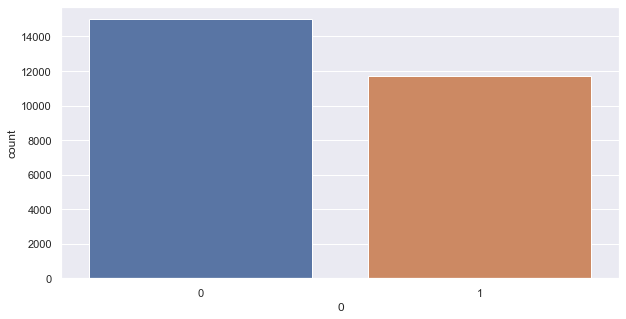

In [12]:
sns.set(rc={'figure.figsize':(10, 5)})
sns.countplot(x = la[0], data = la)

In [13]:
headline_len = [len(i.split()) for i in sentences]
avg_headline_len = np.mean(headline_len)
avg_headline_len

9.845819761129208

(array([2.1410e+03, 1.0229e+04, 1.1190e+04, 2.5140e+03, 5.7200e+02,
        5.2000e+01, 4.0000e+00, 5.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([ 2. ,  5.7,  9.4, 13.1, 16.8, 20.5, 24.2, 27.9, 31.6, 35.3, 39. ]),
 <BarContainer object of 10 artists>)

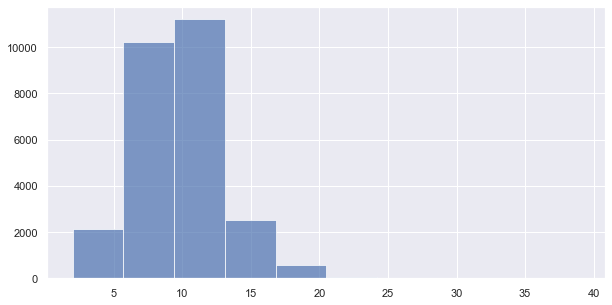

In [14]:
plt.hist(headline_len, alpha=0.7,log=False)

In [15]:
max(headline_len)

39

# Train, Validation dataset segmentation

In [16]:
training_size = 20000

In [17]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

**Tokenizer**

Vocab_size means that in Tokenization, only 1000 words with high maximum frequency will be used and the rest will be processed.

In [18]:
vocab_size = 1000
embedding_dim = 16
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [19]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

Sentences composed of words were converted into numerical values that the machine could understand through Tokenizer.

In [20]:
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Create a Model

**model 1 : Bidirectional GRU(32) + Dropout(0.5)**

In [21]:
model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
        tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
])

In [22]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
num_epochs = 50 
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)
history = model.fit(training_padded, training_labels, epochs=num_epochs,
                    validation_data=(testing_padded, testing_labels), verbose=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           16000     
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                9600      
_________________________________________________________________
dense (Dense)                (None, 24)                1560      
_________________________________________________________________
dropout (Dropout)            (None, 24)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 27,185
Trainable params: 27,185
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
625/625 [==============================] - 12s 17ms/step - loss: 0.4841 - accuracy: 0.7562 - val_loss: 0.42

625/625 [==============================] - 11s 18ms/step - loss: 0.0924 - accuracy: 0.9510 - val_loss: 1.6319 - val_accuracy: 0.8000


**model 2 : Bidirectional GRU(64) + Dropout(0.5)**

In [23]:
model2 = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
        tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64)),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')
])

In [24]:
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.summary()
num_epochs = 50 
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)
history2 = model2.fit(training_padded, training_labels, epochs=num_epochs,
                    validation_data=(testing_padded, testing_labels), verbose=1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 16)           16000     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               31488     
_________________________________________________________________
dense_2 (Dense)              (None, 24)                3096      
_________________________________________________________________
dropout_1 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 25        
Total params: 50,609
Trainable params: 50,609
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
625/625 [==============================] - 17s 24ms/step - loss: 0.4676 - accuracy: 0.7650 - val_loss: 0.

625/625 [==============================] - 20s 32ms/step - loss: 0.0727 - accuracy: 0.9616 - val_loss: 1.7789 - val_accuracy: 0.8070


**model 3 : Bidirectional GRU(64) without Dropout**

In [25]:
model3 = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
        tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64)),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
])

In [26]:
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model3.summary()
num_epochs = 50 
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)
history3 = model3.fit(training_padded, training_labels, epochs=num_epochs,
                    validation_data=(testing_padded, testing_labels), verbose=1)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 120, 16)           16000     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               31488     
_________________________________________________________________
dense_4 (Dense)              (None, 24)                3096      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 25        
Total params: 50,609
Trainable params: 50,609
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
625/625 [==============================] - 24s 35ms/step - loss: 0.4457 - accuracy: 0.7774 - val_loss: 0.3920 - val_accuracy: 0.8258
Epoch 2/50
625/625 [==============================] - 21s 33ms/step - loss: 0.3644 - accuracy: 0.8299 - 

**model 4 : Bidirectional LSTM + Dropout(0.5)**

In [27]:
model4 = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
        tf.keras.layers.Bidirectional(LSTM(32)),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
])

In [28]:
model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model4.summary()
num_epochs = 50 
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)
history4 = model4.fit(training_padded, training_labels, epochs=num_epochs,
                    validation_data=(testing_padded, testing_labels), verbose=1)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 120, 16)           16000     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                12544     
_________________________________________________________________
dense_6 (Dense)              (None, 24)                1560      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 25        
Total params: 30,129
Trainable params: 30,129
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
625/625 [==============================] - 17s 24ms/step - loss: 0.4576 - accuracy: 0.7682 - val_loss: 0.4042 - val_accuracy: 0.8109
Epoch 2/50
625/625 [==============================] - 14s 23ms/step - loss: 0.3567 - accuracy: 0.8368 - 

**model 5 : Two Bidirectional LSTM + Dropout(0.2)**

In [29]:
model5 = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
])

In [30]:
model5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model5.summary()
num_epochs = 50 
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)
history5 = model5.fit(training_padded, training_labels, epochs=num_epochs,
                    validation_data=(testing_padded, testing_labels), verbose=1)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 120, 16)           16000     
_________________________________________________________________
bidirectional_4 (Bidirection (None, 120, 128)          41472     
_________________________________________________________________
dropout_2 (Dropout)          (None, 120, 128)          0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 102,913
Trainable params: 102,913
Non-trainable params: 0
________________________________________________

625/625 [==============================] - 42s 67ms/step - loss: 0.0690 - accuracy: 0.9702 - val_loss: 1.2055 - val_accuracy: 0.8038
Epoch 50/50
625/625 [==============================] - 43s 69ms/step - loss: 0.0623 - accuracy: 0.9728 - val_loss: 1.3004 - val_accuracy: 0.8018


**model 6 : GlobalAveragePooling1D + Flatten + Dropout**

In [31]:
model6 = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(32, activation = 'relu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(1, activation = 'sigmoid') 
])

In [32]:
model6.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model6.summary()
num_epochs = 50 
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)
history6 = model6.fit(training_padded, training_labels, epochs=num_epochs,
                    validation_data=(testing_padded, testing_labels), verbose=1)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 120, 16)           16000     
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
flatten (Flatten)            (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                544       
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 16,577
Trainable params: 16,577
Non-trainable params: 0
__________________________________________________

Epoch 50/50
625/625 [==============================] - 1s 909us/step - loss: 0.3255 - accuracy: 0.8529 - val_loss: 0.4250 - val_accuracy: 0.8132


**model 7 : GlobalMaxPool1D + Five Dense layer + Dropout**

In [34]:
model7 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(16, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [37]:
model7.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model7.summary()
num_epochs = 50 
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)
history7 = model7.fit(training_padded, training_labels, epochs=num_epochs,
                    validation_data=(testing_padded, testing_labels), verbose=1)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 120, 16)           16000     
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               2176      
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 32)               

Epoch 46/50
625/625 [==============================] - 1s 1ms/step - loss: 0.0808 - accuracy: 0.9645 - val_loss: 2.1431 - val_accuracy: 0.7767
Epoch 47/50
625/625 [==============================] - 1s 1ms/step - loss: 0.0781 - accuracy: 0.9647 - val_loss: 2.4496 - val_accuracy: 0.7763
Epoch 48/50
625/625 [==============================] - 1s 1ms/step - loss: 0.0769 - accuracy: 0.9653 - val_loss: 2.1816 - val_accuracy: 0.7760
Epoch 49/50
625/625 [==============================] - 1s 1ms/step - loss: 0.0755 - accuracy: 0.9657 - val_loss: 2.4857 - val_accuracy: 0.7755
Epoch 50/50
625/625 [==============================] - 1s 1ms/step - loss: 0.0747 - accuracy: 0.9658 - val_loss: 2.5083 - val_accuracy: 0.7767


# Result

Judging from the Validation accuracy, Model 6 is the best.

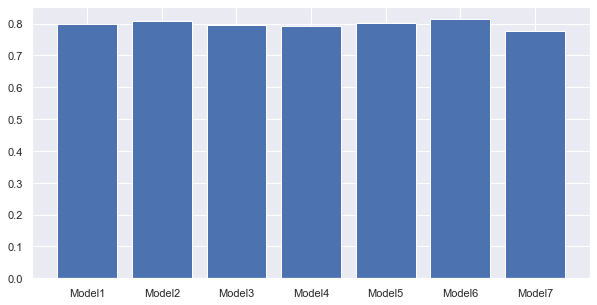

In [42]:
mdl = ['Model1', 'Model2', 'Model3','Model4',"Model5","Model6","Model7"]
values = [0.8000,0.8070, 0.7951,0.7934,0.8018,0.8132,0.7767]

plt.bar(mdl, values)
plt.show()

In [43]:
results = pd.DataFrame({"Model1": history.history['val_loss'],
                        "Model2": history2.history['val_loss'],
                        "Model3": history3.history['val_loss'],
                        "Model4": history4.history['val_loss'],
                        "Model5": history5.history['val_loss'],
                        "Model6": history6.history['val_loss'],
                        "Model7": history7.history['val_loss']})
results = results.transpose()
results

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
Model1,0.425284,0.389414,0.380955,0.373217,0.376736,0.374676,0.391866,0.383229,0.390366,0.413427,...,1.302416,1.522955,1.383912,1.473976,1.578911,1.566894,1.455425,1.513548,1.535217,1.631875
Model2,0.392537,0.423906,0.370516,0.372582,0.379741,0.385605,0.382389,0.384230,0.384231,0.406425,...,1.463837,1.596568,1.621616,1.567529,1.451173,1.468308,1.689512,1.706476,1.648269,1.778908
Model3,0.391986,0.381737,0.369241,0.386952,0.369966,0.374519,0.379966,0.402417,0.421033,0.407250,...,1.556250,1.701621,1.600432,1.584757,1.718396,1.813534,1.679989,1.773308,1.939632,1.819572
Model4,0.404249,0.382328,0.370225,0.370373,0.390383,0.382585,0.393861,0.397562,0.413725,0.403851,...,1.419473,1.411667,1.615072,1.485246,1.603770,1.623766,1.585889,1.707981,1.640977,1.757075
Model5,0.394545,0.391795,0.372985,0.370822,0.376767,0.379507,0.379932,0.425667,0.418959,0.432991,...,1.109800,1.135941,1.176347,1.196638,1.171453,1.293440,1.217162,1.221258,1.205464,1.300399
Model6,0.619293,0.447259,0.417584,0.402749,0.410627,0.400238,0.403028,0.403662,0.411198,0.413505,...,0.417522,0.426092,0.412746,0.415709,0.412800,0.413602,0.416293,0.412595,0.421670,0.425010
Model7,0.440771,0.415858,0.428556,0.420205,0.427861,0.437843,0.462246,0.488795,0.526272,0.581243,...,2.233078,2.458354,2.133640,2.150899,2.572515,2.143102,2.449607,2.181553,2.485736,2.508272


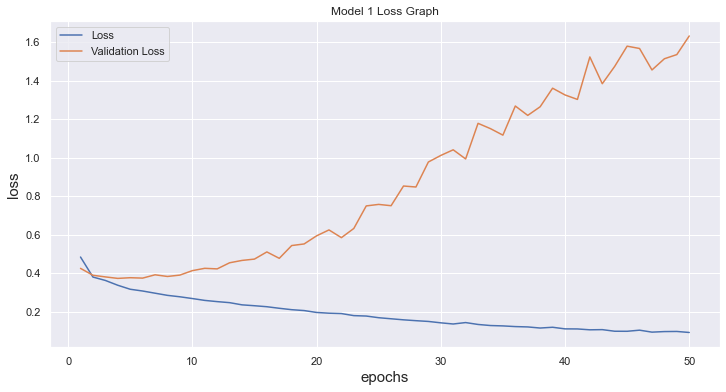

In [44]:
plt.figure(figsize=(12, 6))
plt.plot(np.arange(50)+1, history.history['loss'], label='Loss')
plt.plot(np.arange(50)+1, history.history['val_loss'], label='Validation Loss')

plt.xlabel('epochs', fontsize=15)
plt.ylabel('loss', fontsize=15)
plt.title("Model 1 Loss Graph")

plt.legend()
plt.show()

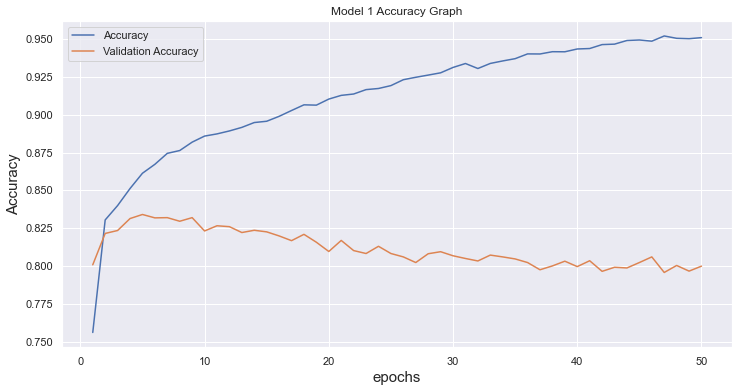

In [45]:
plt.figure(figsize=(12, 6))
plt.plot(np.arange(50)+1, history.history['accuracy'], label='Accuracy')
plt.plot(np.arange(50)+1, history.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel('epochs', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.title("Model 1 Accuracy Graph")
plt.legend()
plt.show()

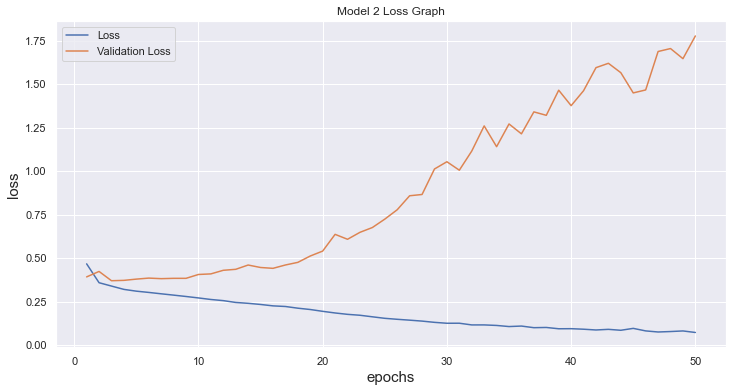

In [46]:
plt.figure(figsize=(12, 6))
plt.plot(np.arange(50)+1, history2.history['loss'], label='Loss')
plt.plot(np.arange(50)+1, history2.history['val_loss'], label='Validation Loss')

plt.xlabel('epochs', fontsize=15)
plt.ylabel('loss', fontsize=15)
plt.title("Model 2 Loss Graph")

plt.legend()
plt.show()

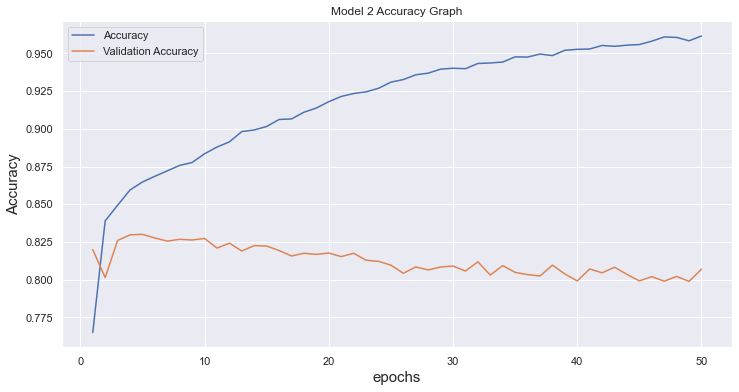

In [47]:
plt.figure(figsize=(12, 6))
plt.plot(np.arange(50)+1, history2.history['accuracy'], label='Accuracy')
plt.plot(np.arange(50)+1, history2.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel('epochs', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.title("Model 2 Accuracy Graph")
plt.legend()
plt.show()

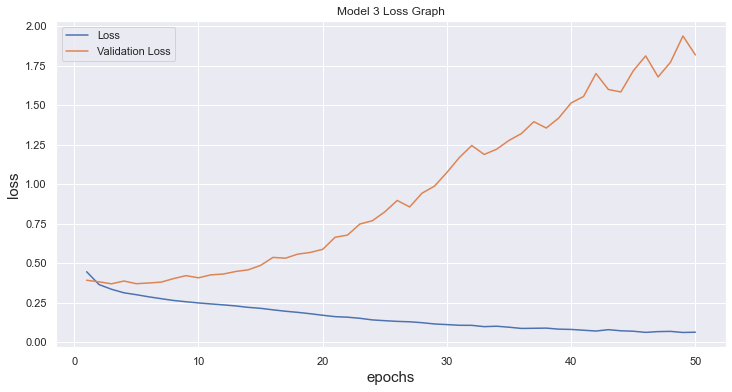

In [48]:
plt.figure(figsize=(12, 6))
plt.plot(np.arange(50)+1, history3.history['loss'], label='Loss')
plt.plot(np.arange(50)+1, history3.history['val_loss'], label='Validation Loss')

plt.xlabel('epochs', fontsize=15)
plt.ylabel('loss', fontsize=15)
plt.title("Model 3 Loss Graph")

plt.legend()
plt.show()

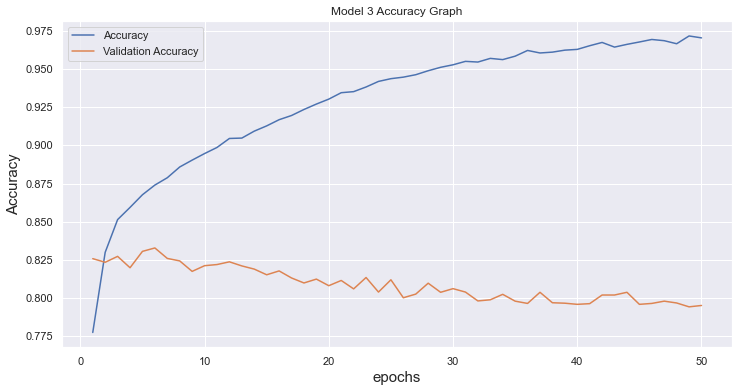

In [49]:
plt.figure(figsize=(12, 6))
plt.plot(np.arange(50)+1, history3.history['accuracy'], label='Accuracy')
plt.plot(np.arange(50)+1, history3.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel('epochs', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.title("Model 3 Accuracy Graph")
plt.legend()
plt.show()

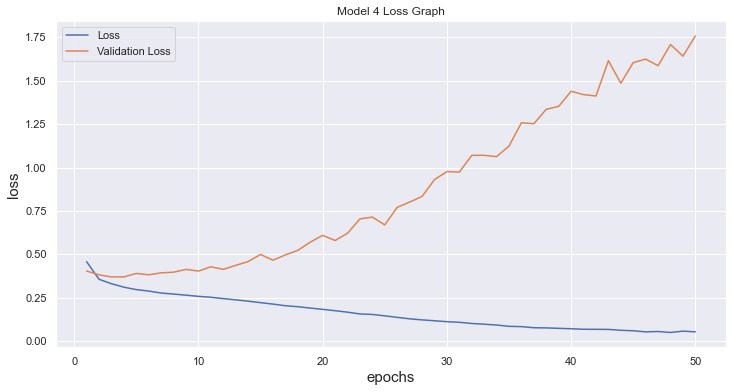

In [50]:
plt.figure(figsize=(12, 6))
plt.plot(np.arange(50)+1, history4.history['loss'], label='Loss')
plt.plot(np.arange(50)+1, history4.history['val_loss'], label='Validation Loss')

plt.xlabel('epochs', fontsize=15)
plt.ylabel('loss', fontsize=15)
plt.title("Model 4 Loss Graph")

plt.legend()
plt.show()

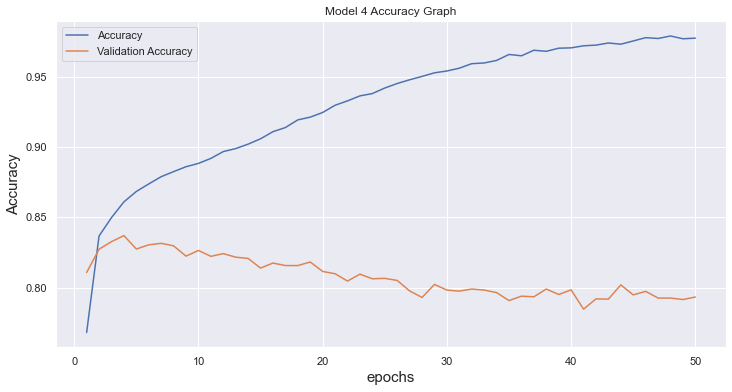

In [51]:
plt.figure(figsize=(12, 6))
plt.plot(np.arange(50)+1, history4.history['accuracy'], label='Accuracy')
plt.plot(np.arange(50)+1, history4.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel('epochs', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.title("Model 4 Accuracy Graph")
plt.legend()
plt.show()

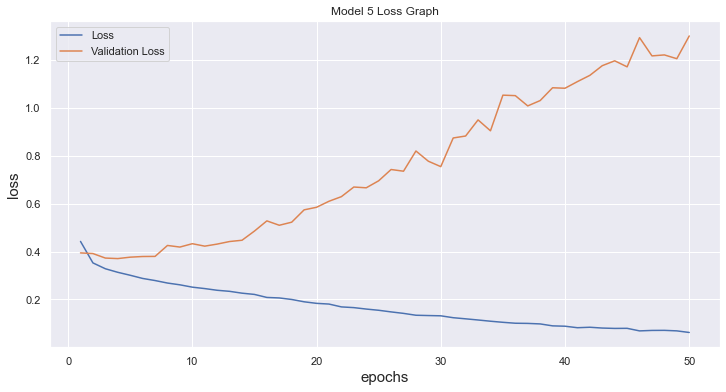

In [52]:
plt.figure(figsize=(12, 6))
plt.plot(np.arange(50)+1, history5.history['loss'], label='Loss')
plt.plot(np.arange(50)+1, history5.history['val_loss'], label='Validation Loss')

plt.xlabel('epochs', fontsize=15)
plt.ylabel('loss', fontsize=15)
plt.title("Model 5 Loss Graph")

plt.legend()
plt.show()

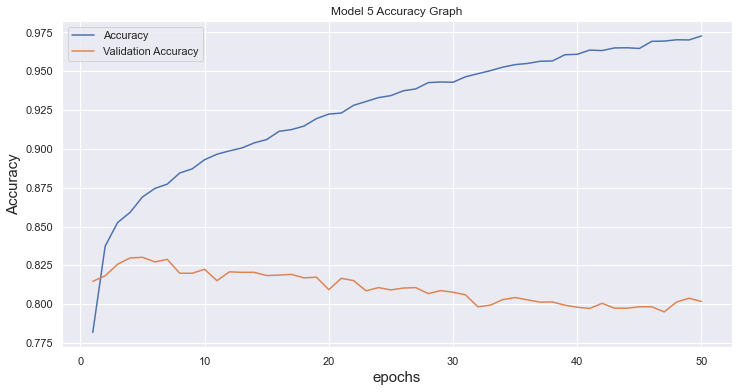

In [53]:
plt.figure(figsize=(12, 6))
plt.plot(np.arange(50)+1, history5.history['accuracy'], label='Accuracy')
plt.plot(np.arange(50)+1, history5.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over training', fontsize=20)

plt.xlabel('epochs', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.title("Model 5 Accuracy Graph")
plt.legend()
plt.show()

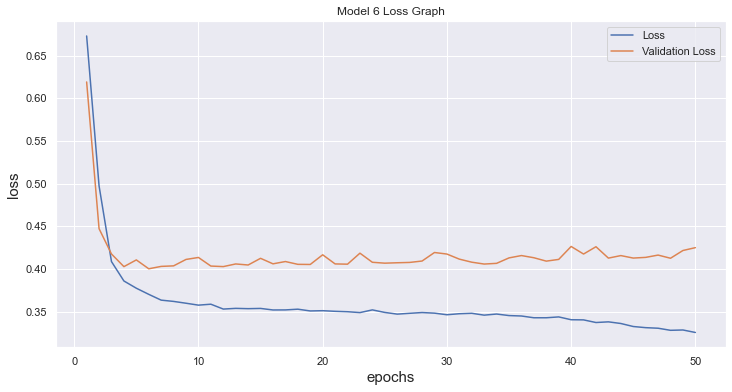

In [56]:
plt.figure(figsize=(12, 6))
plt.plot(np.arange(50)+1, history6.history['loss'], label='Loss')
plt.plot(np.arange(50)+1, history6.history['val_loss'], label='Validation Loss')
plt.title("Model 6 Loss Graph")
plt.xlabel('epochs', fontsize=15)
plt.ylabel('loss', fontsize=15)

plt.legend()
plt.show()

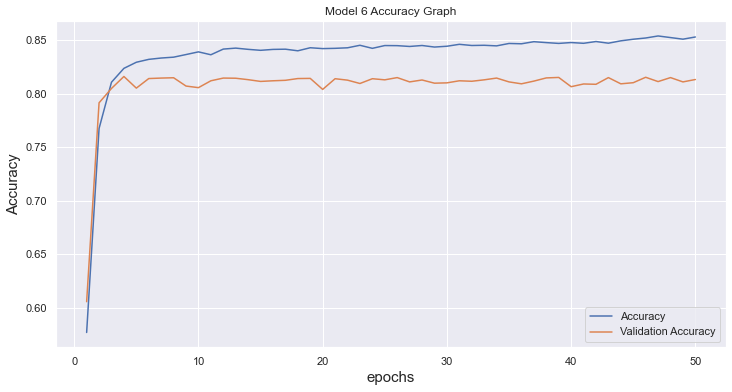

In [57]:
plt.figure(figsize=(12, 6))
plt.plot(np.arange(50)+1, history6.history['accuracy'], label='Accuracy')
plt.plot(np.arange(50)+1, history6.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel('epochs', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.title("Model 6 Accuracy Graph")

plt.legend()
plt.show()

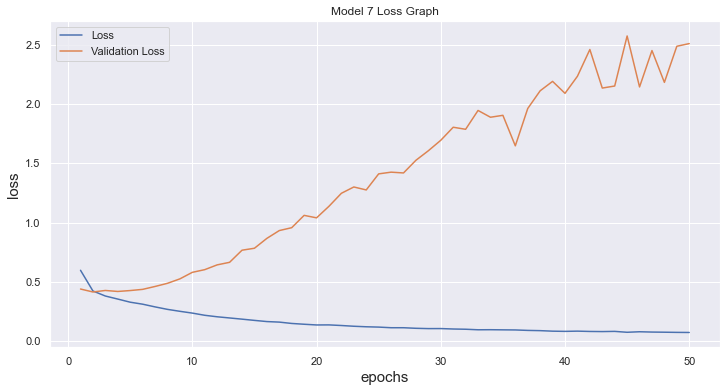

In [58]:
plt.figure(figsize=(12, 6))
plt.plot(np.arange(50)+1, history7.history['loss'], label='Loss')
plt.plot(np.arange(50)+1, history7.history['val_loss'], label='Validation Loss')

plt.xlabel('epochs', fontsize=15)
plt.ylabel('loss', fontsize=15)
plt.title("Model 7 Loss Graph")
plt.legend()
plt.show()

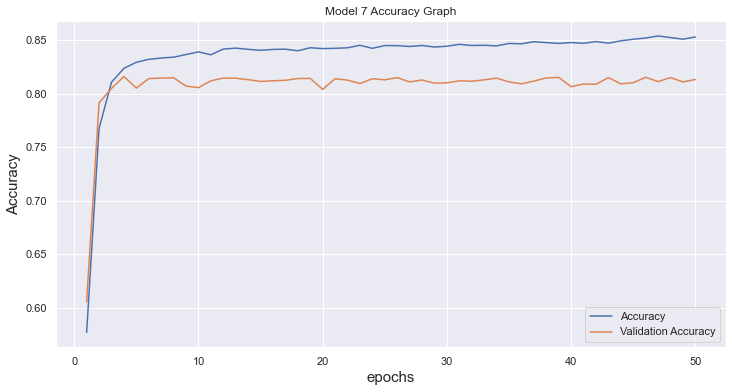

In [59]:
plt.figure(figsize=(12, 6))
plt.plot(np.arange(50)+1, history6.history['accuracy'], label='Accuracy')
plt.plot(np.arange(50)+1, history6.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel('epochs', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.title("Model 7 Accuracy Graph")
plt.legend()
plt.show()

**Conclusion**

**Model 6 has the smallest loss and the highest accuracy. And convergence is observed, and Overfitting seems to be the most improved.**